# Bias-Variance Trade-off and Decomposition

One of the critical concepts in data science is the **bias-variance** trade-off. This expresses how certain hyper-parameters affect the error of a model, and how the best model is achieved by finding the minimum error.

The error is often decomposed into **bias** and **variance**. These are theoretical concepts. To calculate bias and variance we need to understand the population, so we can't measure the bias or variance from a sample.

This notebook is an exploration of bias and variance of various models, on a simple fake dataset with one feature.

$\DeclareMathOperator{\E}{\mathbb{E}}$
$\DeclareMathOperator{\Bias}{Bias}$
$\DeclareMathOperator{\Var}{Var}$

Suppose there is some underlying true function $f(x)$, such that $y = f(x) + \epsilon$, where the noise $\epsilon$ has a mean of zero and standard deviation of $\sigma$. We've created some function $\hat f(x)$ to estimate $y$, and want the residuals $|y - \hat f(x)|$ to be as small as possible. We can decompose this into three parts: the  square of the **bias**, the **variance**, and the **irreducible error**.

These are independent, so the some of these (as squares) is equal to the square of the total error.

$$\E\left[(y - \hat f(x))^2\right] = \left(\Bias[\hat f(x)]\right)^2 + \Var[\hat f(x)] + \sigma^2$$

where
$$\Bias[\hat f(x)] = \E[\hat f(x)] - f(x)$$
and
$$\text{Var}[\hat f(x)] = \E[\hat f(x)^2] - \E[\hat f(x)]^2$$


TBD: add derivation.

$$
\begin{align}
\E\left[(y - \hat f(x))^2\right] & = \E\left[(f(x) + \epsilon -
     \hat f(x) +
     \E[\hat f(x)] - \E[\hat f(x)
     )^2\right] \\
     & = 
\end{align}$$

Let's show an example, following the notation above. For our fake dataset, we take $\sigma$ to be 1, the irreducible error to be normally distributed, and $f(x)$ to be a cosine.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline

#from tensorflow import keras

In [2]:
sigma = 1

def f(x):
    return np.cos(x)

def epsilon(x):
    return stats.norm(0, sigma).rvs(x.shape)

def y(x):
    return f(x) + epsilon(x)

Now we'll look at it in some range, say, 0 to 15.

In [3]:
xlim = (0, 15)
n_pts = 100
xpts = np.linspace(*xlim, n_pts)
ypts = f(xpts)

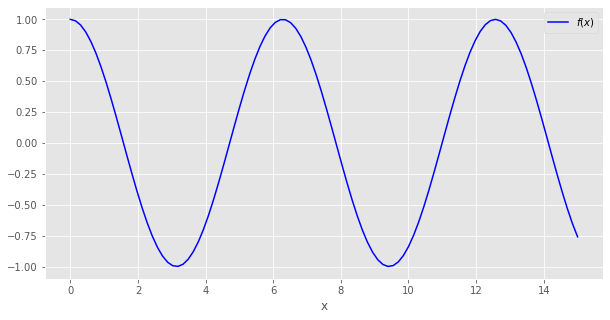

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xpts, ypts, 'b-', label='$f(x)$')
ax.legend()
ax.set_xlabel('x');

Now we'll choose a training sample and fit a model to those data. We'll start with a kNN regressor, first with `k=3`.

In [5]:
x_sample = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs(n_pts)
y_sample = y(x_sample)
model = KNeighborsRegressor(3)
model.fit(x_sample[:, None], y_sample)

KNeighborsRegressor(n_neighbors=3)

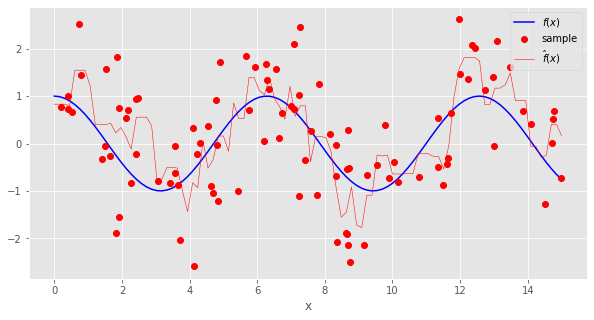

In [6]:
points = ax.plot(x_sample, y_sample, 'ro', label='sample')
ax.plot(xpts, model.predict(xpts[:, None]), 'r-', lw=0.5, label='$\hat{f}(x)$')
ax.legend()
fig

So: $f(x)$ is the underlying function, $\hat{f}(x)$ is values predicted from the model build with the sample some training sample.

Let's look at the values of  $\hat{f}(x)$ over a whole bunch of samples, and the average of all of those  $\E[\hat f(x)]$.

First, we'll create a class to handle this.

In [7]:
class BiasVarianceRenderer:
    color_bias = 'k'
    color_variance = 'b'
    color_noise = 'g'
    color_error = 'r'
    
    def __init__(self,
                 f,
                 xlim,
                 noise=stats.norm(0, 1),
                 npts=250,
                 sample_size=100,
                 n_trials=200):
        """Create basic class.
        Parameters
            noise: scipy frozen distribution (assume homoskedacity)
            """
        self.n_pts = n_pts
        self.f = f
        self.noise = noise
        self.xlim = xlim
        self.sample_size = sample_size
        self.n_trials = n_trials
        self.predictions_to_plot = 50  # don't plot predictions from every sample or it's too noisy
        
    def generate_f(self):
        """Generate background points of function"""
        self.xpts = np.linspace(*self.xlim, self.n_pts)
        self.ypts = self.f(self.xpts)

    def generate_samples(self):
        """Generate a bunch of samples from the distributions along with the actual values"""
        self.x_samples = stats.uniform(self.xlim[0],
                                       self.xlim[1]-self.xlim[0]).rvs((self.sample_size,
                                                                       self.n_trials))
        
        self.y_samples = self.f(self.x_samples) + self.noise.rvs(self.x_samples.shape)

        
    def calculate_statistics(self, model):
        predictions = np.zeros((self.n_trials, self.n_pts))
        for t in range(self.n_trials):
            x_sample = self.x_samples[:, t]
            y_sample = self.y_samples[:, t]
            model.fit(x_sample[:, None],
                      y_sample)
            predictions[t, :] = model.predict(self.xpts[:, None])
        bias2 = (predictions.mean(axis=0) - ypts)**2
        variance = predictions.var(axis=0)
        error2 = ((predictions - ypts)**2).mean(axis=0) + self.noise.var()
        return predictions, bias2, variance, error2
        
    def plot_panel_pair(self, ax1, ax2, model, label, include_legend=True):
        """Plot a pair of 
        """

        predictions, bias2, variance, error2 = self.calculate_statistics(model)
        
        for t in range(min(self.predictions_to_plot, self.n_trials)):
            ax1.plot(self.xpts, predictions[t,:], 'r-', lw=0.1)

        ax1.plot(self.xpts, self.ypts, 'k-', label='$f(x)$')
        ax1.plot(self.xpts, predictions.mean(axis=0), color='#AA0000', lw=3, label="$E[\hat f(x)]$")

        ax1.set_ylim((-2, 2)) # I shound't hard-code this
        ax1.set_title(label)
        if include_legend:
            ax1.legend()

        ax2.plot(self.xpts, bias2, self.color_bias, label=r'$\mathrm{bias}^2$')
        ax2.plot(self.xpts, variance, self.color_variance, label='variance')
        ax2.plot(self.xpts, error2, self.color_error, label=r'$\mathrm{total}^2$')
        ax2.axhline(bias2.mean(), color=self.color_bias, ls=':')
        ax2.axhline(variance.mean(), color=self.color_variance, ls=':')
        ax2.axhline(error2.mean(), color=self.color_error, ls=':')
        ax2.axhline(self.noise.var(), color=self.color_noise, ls=':', label='$\sigma^2$')
        ax2.axhline(0, color='k', lw=0.5)

        if include_legend:
            ax2.legend()

    def plot(self, fig, base_model, values, label):
        for i, value in enumerate(values, start=1):
            model = base_model(value)
            if i == 1:
                first_ax1 = ax1 = fig.add_subplot(2, len(values), i)
                first_ax2 = ax2 = fig.add_subplot(2, len(values), i + len(values), sharex=first_ax1)
            else:
                ax1 = fig.add_subplot(2, len(values), i, sharex=first_ax1, sharey=first_ax1)
                ax2 = fig.add_subplot(2, len(values), i + len(values), sharex=first_ax2, sharey=first_ax2)
            self.plot_panel_pair(ax1, ax2,
                                 model=model,
                                 label=label.format(value),
                                 include_legend=(i==1))
    def plot_bv(self, ax, base_model, values, label):
        """Plot bias and variance"""
        
        bias2s = []
        variances = []
        noises = [self.noise.var()] * len(values)
        error2s = []
        
        for i, value in enumerate(values):
            model = base_model(value)

            _, bias2, variance, error2 = self.calculate_statistics(model)
            bias2s.append(bias2.mean())
            variances.append(variance.mean())
            error2s.append(error2.mean())
            
        ax.plot(values, bias2s, '.-', ms=15, color=self.color_bias, label=r'$\mathrm{bias}^2$')
        ax.plot(values, variances, '.-', ms=15, color=self.color_variance, label='variance')
        ax.plot(values, noises, '.-', ms=15, color=self.color_noise, label='$\sigma^2$')
        ax.plot(values, error2s, '.-', ms=15, color=self.color_error, label=r'$\mathrm{total error}^2$')
        
        ax.set_xticks(values)
        ax.set_xlabel(label)
        ax.set_ylabel("squared error")
        ax.legend()


In [8]:
bvr = BiasVarianceRenderer(f=np.cos,
                           xlim=(0, 15),
                           noise=stats.norm(0, 1),
                           sample_size=30, n_trials=200)
bvr.generate_f()
bvr.generate_samples()

# kNN model

We'll start investigating a kNN model, since it's pretty simple, has a very nice hyper-parameter, and happens to give relatively clean results.

First, let's look at the bias squared, the variance, and the irreducible error ($\sigma^2$) for a range of values of $k$. These graph below shows the average of these across the range we consider; the next graph will show them as a function of $x$.

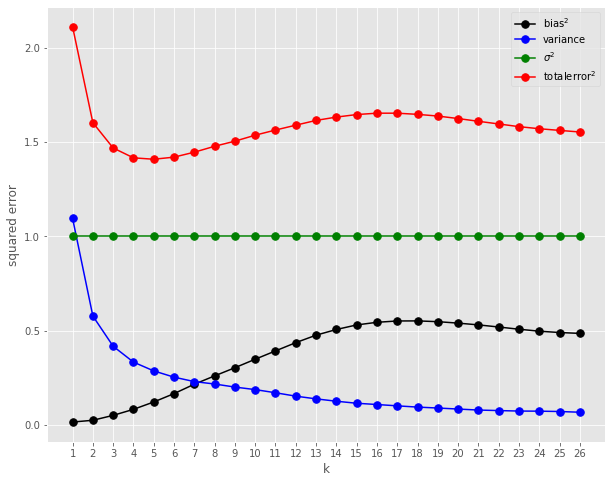

In [9]:
fig, ax = plt.subplots(figsize=(10,8))

bvr.plot_bv(ax=ax,
              base_model=KNeighborsRegressor,
              values=range(1, 27),
              label="k")

Let's look at each term in turn. The irreducible error is independent of the model – that's the part of the error that we can't possibly model no matter what we do, even if we had a model built from the entire population. Realistically, the separation might not be as clean, as there may be predictive features not included, or patterns our model can't discover, but in this case it's pretty easy. Our underlying function is a cosine curve; the irreducible error is the added noise.

Next is the bias squared (all of these are squared error terms; the bias itself might be negative). It starts near zero that increases with increasing $k$. We'll see the source in the next graph, how at higher $k$ the we have trouble fitting the peaks and edges. Bizarrely, the bias starts dropping for large values; this is or first hint that things can get messy.

Finally, the variance steadily decreases. Even for large $k$ when we are predicting the mean of the training sample for everything, we still have a bit of variance (the variance of the mean of the sample).

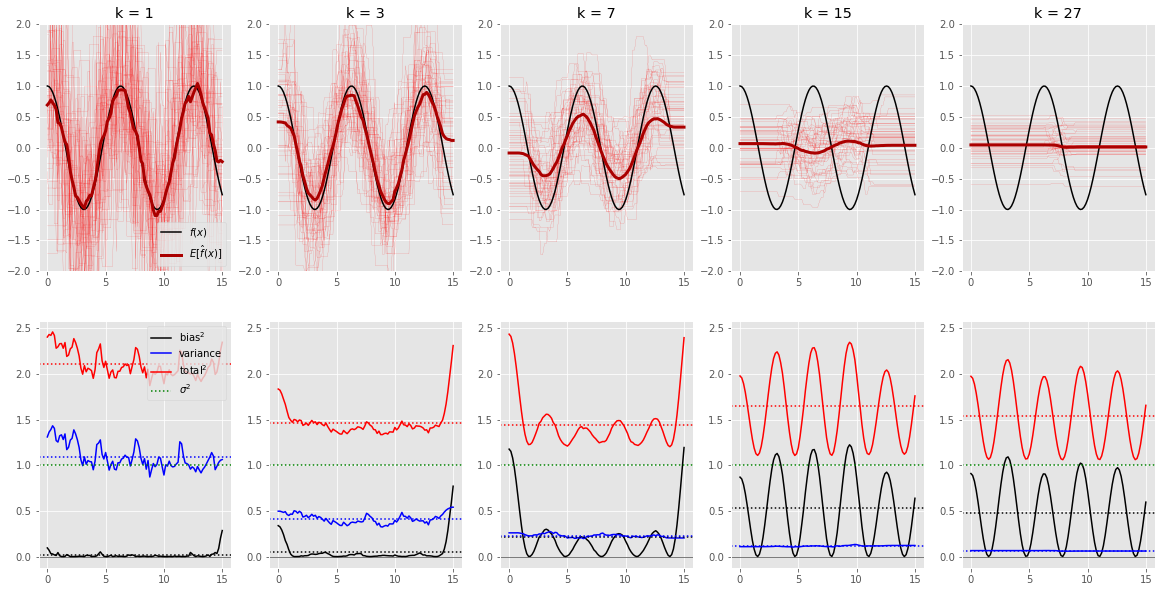

In [10]:
fig = plt.figure(figsize=(20,10))

bvr.plot(fig=fig,
         base_model=KNeighborsRegressor,
         values=(1, 3, 7, 15, 27),
         label="k = {}")

In the graph above, we see two views. Along the top row are a predictions for a models fit on a number of samples. On the left side (for small $k$) there's a lot of variation in the predictions; on the right side (large $k$) very little. The average of these predictions ($E[\hat f(x)]$) is shown by the heavier line, and the underlying function (the cosine) is shown in black.

The different of these two lines is the bias; its square the bottom row in black. The variance is simply the variance of the predictions for each value of $x$; the irreducible error is the same for all models.

The squared bias starts near zero at $k=1$. For larger $k$ the predictions around a peak are smoothed out by values far away. In the extreme case (around $k=15$) the predictions in the top row are in the *opposite direction* as the peaks and valleys, as the prediction for a peak includes the two valleys next to it. As $k$ increases still further, more points are included and the bias drops a bit.

The variance is less dependent on $x$; if there is a pattern, it's higher near the nodes where the nearest point likely has a very different value of $y$. It drops steadily with increasing $k$, as expected.

**Note that the bias<sup>2</sup> isn't exactly zero.** Part of the reason is we didn't use enough samples, but even as that approaches infinity there will still be non-zero values. It's a common misconception that a model that predicts training data exactly will have no bias. We can see otherwise if we decrease the sample size (and increase the number of samples so we get a clean graph).

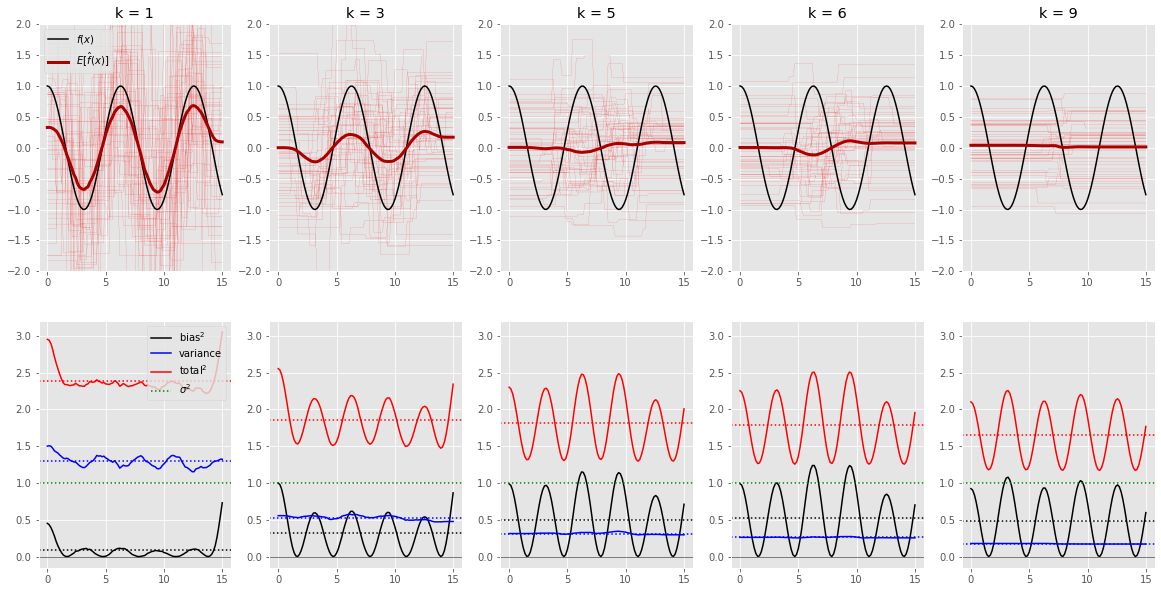

In [11]:
bvr_small = BiasVarianceRenderer(f=np.cos,
                           xlim=(0, 15),
                           noise=stats.norm(0, 1),
                           sample_size=10, n_trials=3000)
bvr_small.generate_f()
bvr_small.generate_samples()

fig = plt.figure(figsize=(20,10))

bvr_small.plot(fig=fig,
         base_model=KNeighborsRegressor,
         values=(1, 3, 5, 6, 9),
         label="k = {}")

Even at $k=1$ we have some bias around the extrema of the original function. That's not surprising: the predictions at a peak will tend to be low, as the nearest point isn't quite on the peak.

Next, we look at the bias and variance for various values of the hyperparameter k using a **k-nearest-neighbors regressor**.

## Decision trees

Let's try the same thing with **Decision Trees**

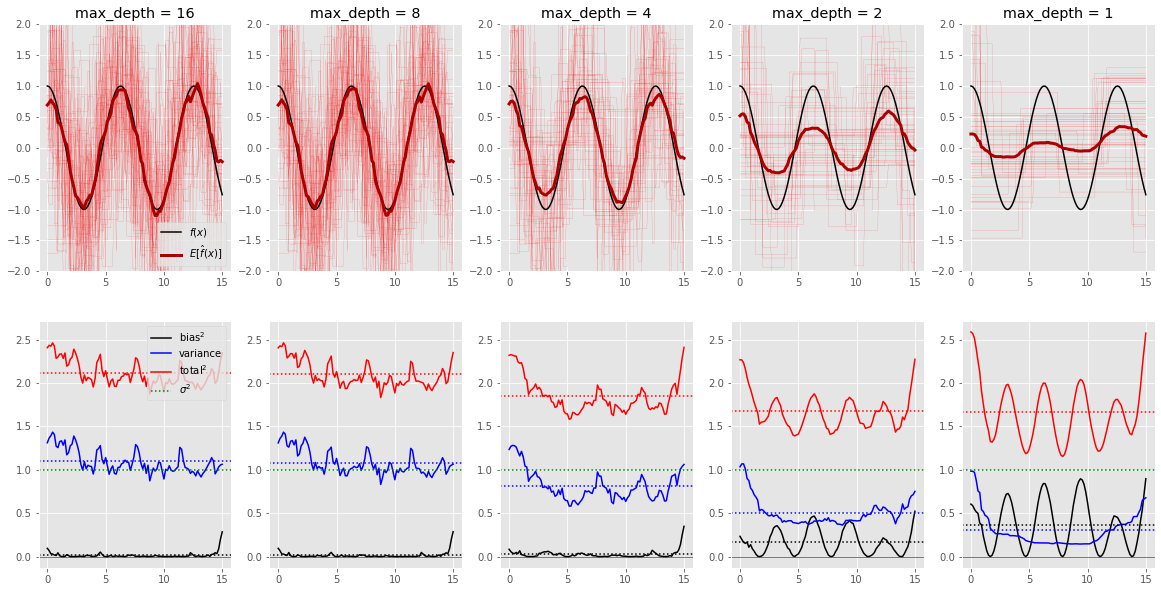

In [12]:
fig = plt.figure(figsize=(20, 10))

bvr.plot(fig=fig,
         base_model=lambda k: DecisionTreeRegressor(max_depth=k),
         values=(16, 8, 4, 2, 1),
         label="max_depth = {}")

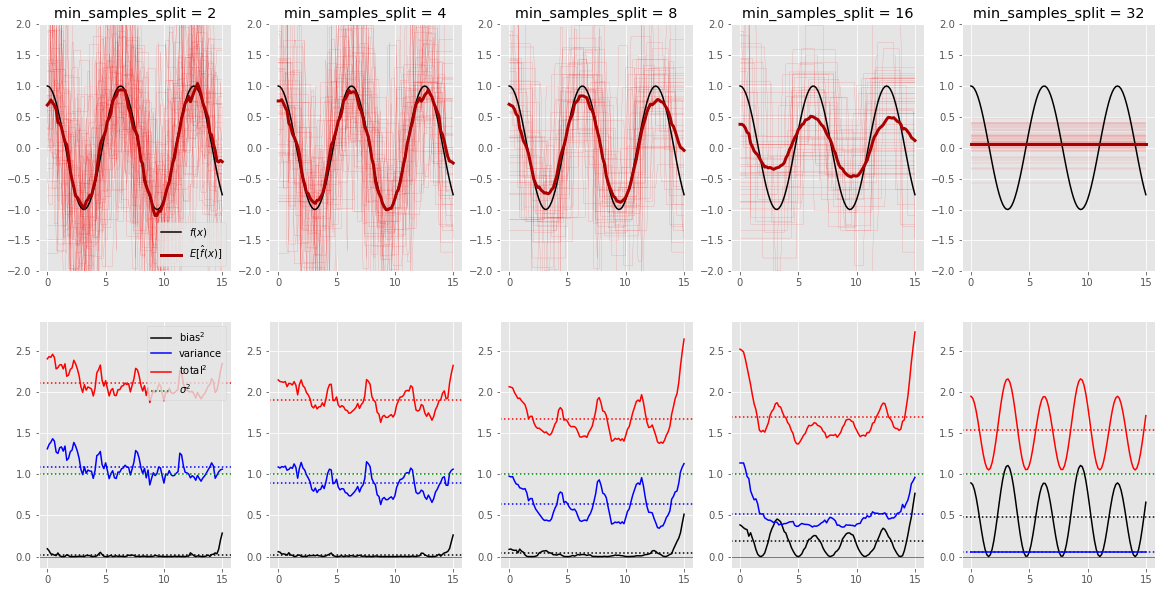

In [13]:
fig = plt.figure(figsize=(20, 10))

bvr.plot(fig=fig,
         base_model=lambda k: DecisionTreeRegressor(min_samples_split=k),
         values=(2, 4, 8, 16, 32),
         label="min_samples_split = {}")

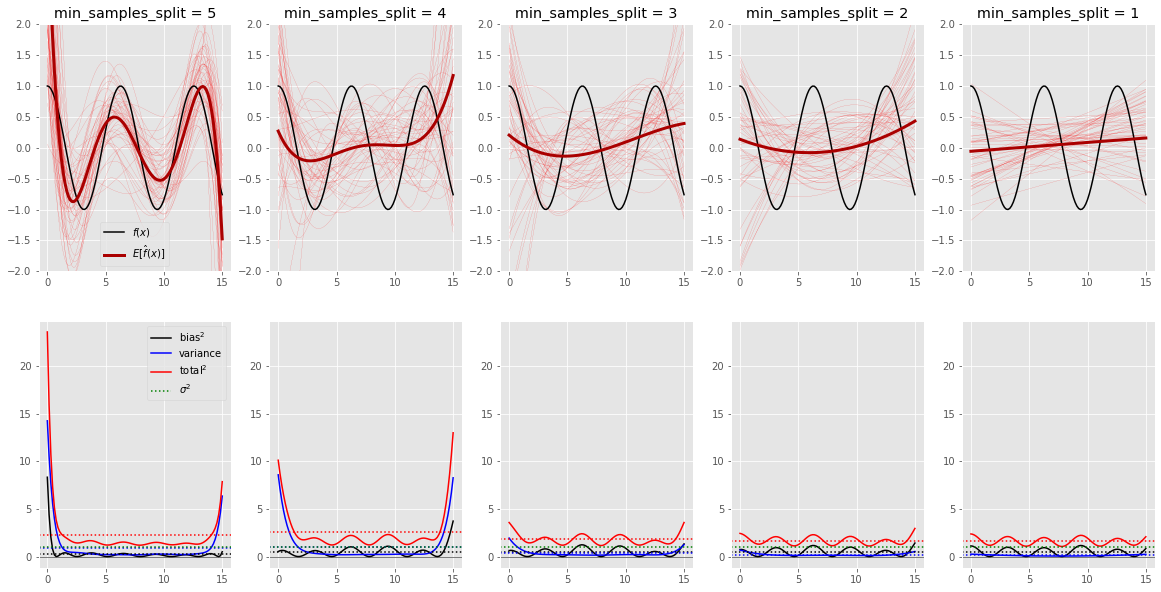

In [14]:
fig = plt.figure(figsize=(20, 10))

bvr.plot(fig=fig,
         base_model=lambda k: Pipeline(steps=[('poly', PolynomialFeatures(k)),
                                              ('lr', LinearRegression())]),
         values=(5, 4, 3, 2, 1),
         label="min_samples_split = {}")

In [15]:
# note: we should really pass in xpts and ypts. Or make this a class

def plot_bias_variance(ax1, ax2, model, x_samples, label):
    n_trials = x_samples.shape[1]
    predictions = np.zeros((n_trials, n_pts))
    for t in range(n_trials):
        x_sample = x_samples[:, t]
        y_sample = y(x_sample)
        model.fit(x_sample[:, None], y_sample)
        predictions[t, :] = model.predict(xpts[:, None])
        ax1.plot(xpts, predictions[t,:], 'r-', lw=0.1)
    ax1.plot(xpts, ypts, 'b-', label='$f(x)$')
    ax1.plot(xpts, predictions.mean(axis=0), color='#AA0000', lw=3, label="$E[\hat f(x)]$")

    ax1.set_ylim((-2, 2))
    ax1.set_title(label)
    ax1.legend()
    #ax[1].plot(xpts, predictions.mean(axis=0) - ypts, 'k', label='bias')
    bias = predictions.mean(axis=0) - ypts
    variance = predictions.var(axis=0)
    error = predictions.mean(axis=0)
    ax2.plot(xpts, bias**2, 'k', label='bias^2')
    ax2.plot(xpts, variance, 'r', label='variance')
    ax2.plot(xpts, bias**2 + variance, 'g', label='bias^2 + variance')
    ax2.plot(xpts, bias**2 + variance, 'g', label='total')
    ax2.plot(xpts, np.zeros_like(xpts), 'k', lw=0.5)
    ax2.axhline(np.mean(bias**2 + variance), color='g', ls=':', label='average total')

    ax2.legend()

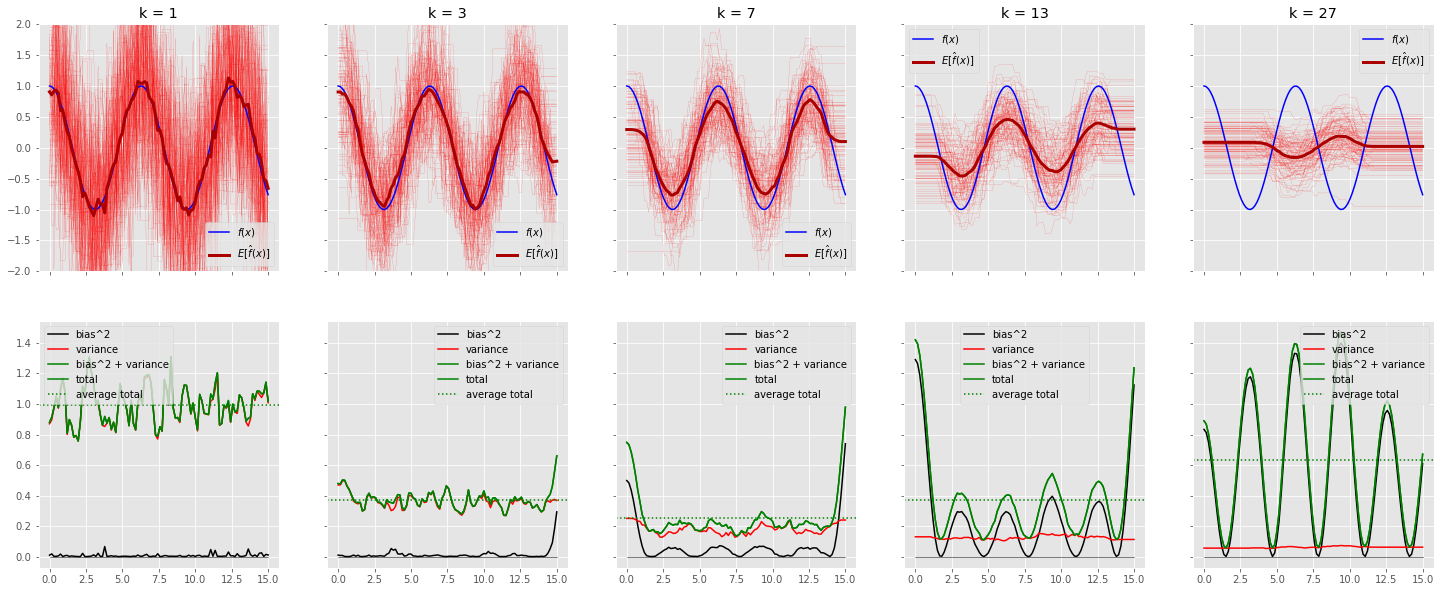

In [16]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

n_trials = 100
sample_size = 50
x_samples = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs((sample_size, n_trials))
for i, k in enumerate((1, 3, 7, 13, 27)):
    model = KNeighborsRegressor(k)
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"k = {k}")

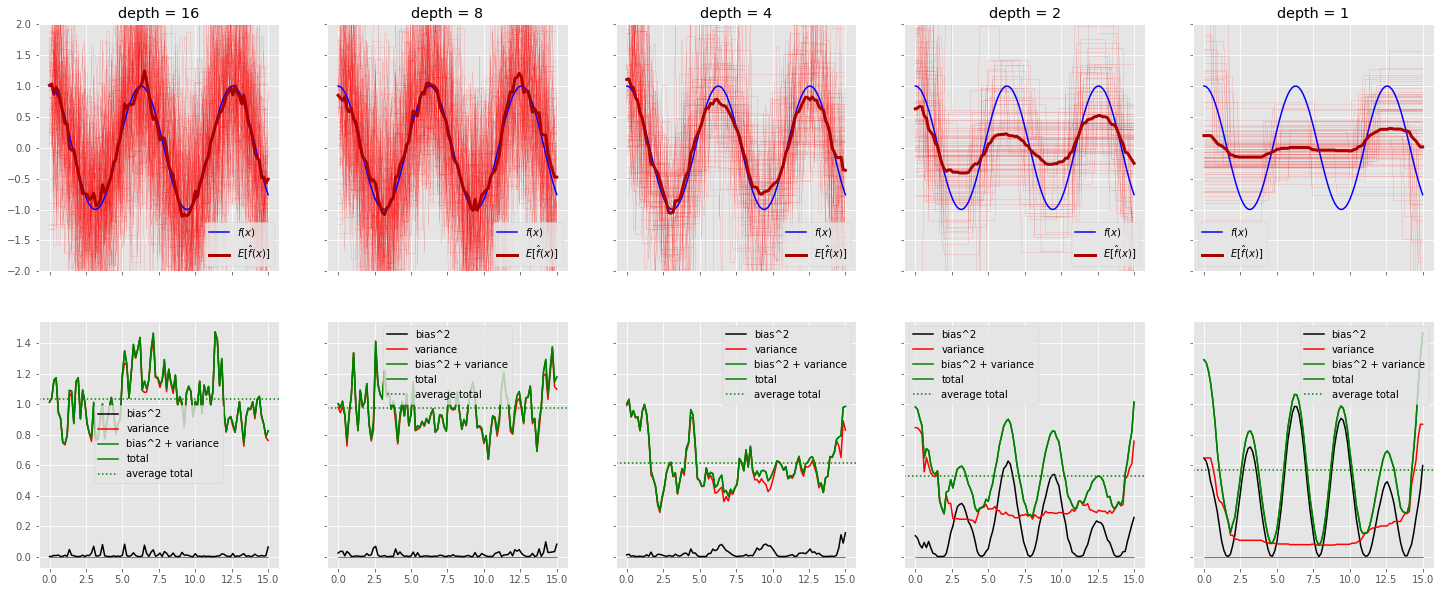

In [17]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

n_trials = 100
sample_size = 50
x_samples = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs((sample_size, n_trials))
for i, depth in enumerate((16, 8, 4, 2, 1)):
    model = DecisionTreeRegressor(max_depth=depth)
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"depth = {depth}")

Interesting. It looks as if it's hard to to better than a depth-1 tree. Let's try a different hyperparameter.

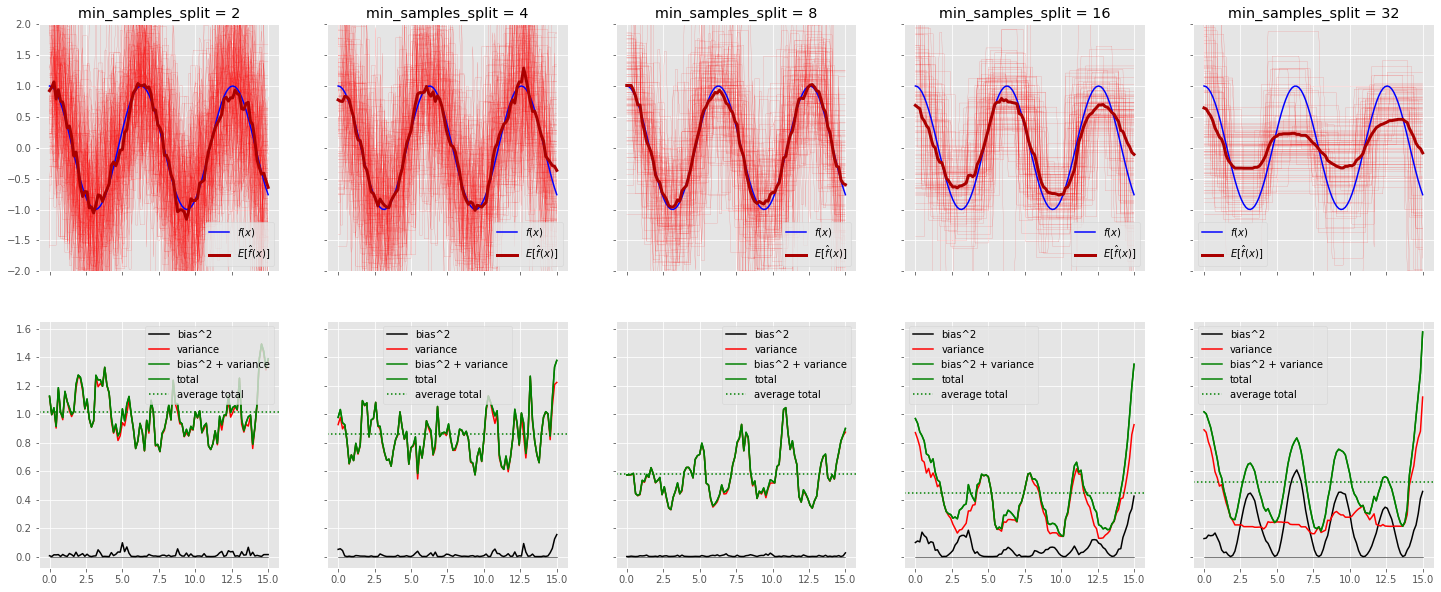

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

n_trials = 100
sample_size = 50
x_samples = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs((sample_size, n_trials))
for i, min_samples_split in enumerate((2, 4, 8, 16, 32)):
    model = DecisionTreeRegressor(min_samples_split=min_samples_split)
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"min_samples_split = {min_samples_split}")

That one seems better.

Now let's try polynomial models.

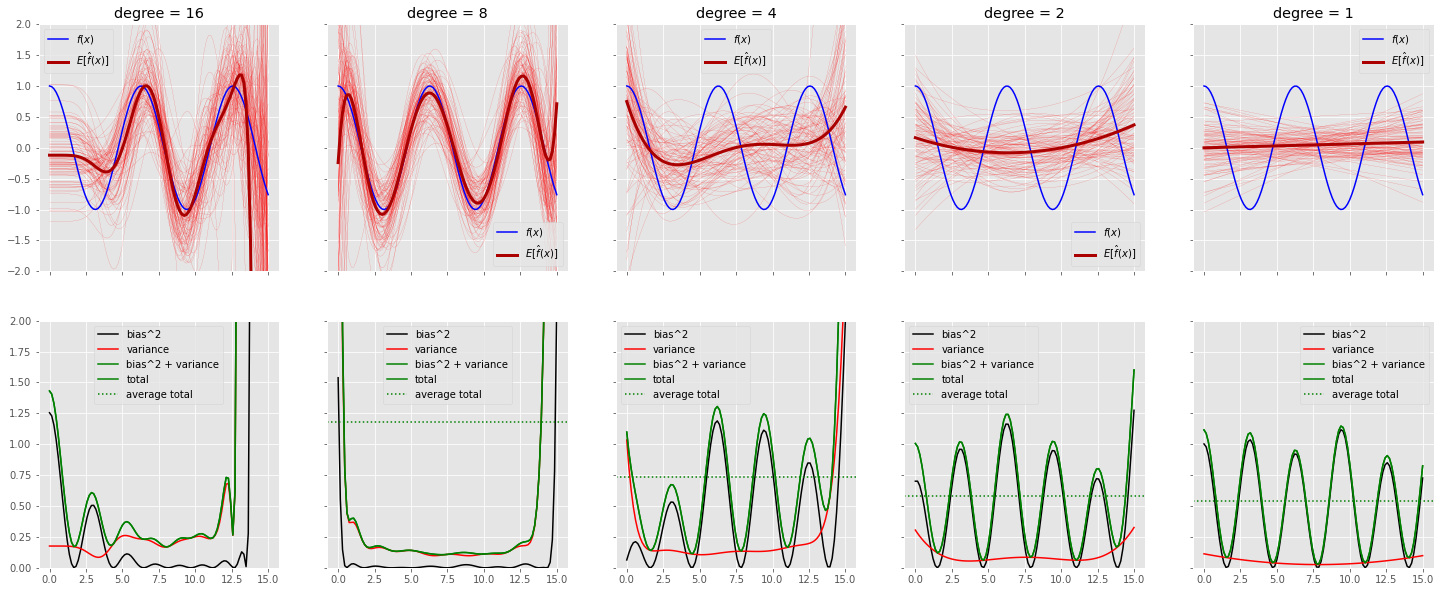

In [19]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

# limit y on the lower graph, because things blow up
axs[1, 0].set_ylim(0, 2)

n_trials = 100
sample_size = 50
x_samples = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs((sample_size, n_trials))
for i, degree in enumerate((16, 8, 4, 2, 1)):
    model = Pipeline(steps=[('poly', PolynomialFeatures(degree)),
                            ('lr', LinearRegression())])
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"degree = {degree}")

One might have expected that the a polynomial of sufficiently high degree would be a great way to predict a cosine. And the total of bias and variance at degree = 8 is really low...except at either end. It's so bad there, it makes the overall average worse than lower orders.

Polynomial regression: not so great.

Let's try it again with Ridge regression, changing $\alpha$, using a degree-five polynomial.

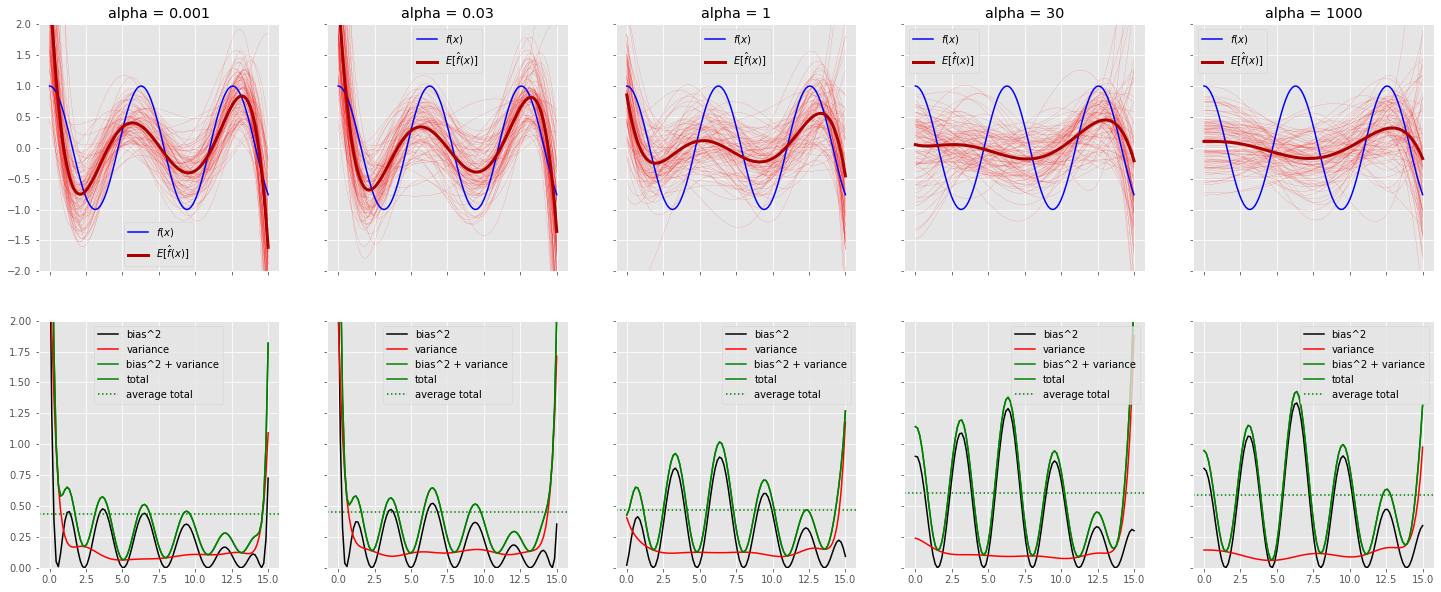

In [20]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

# limit y on the lower graph, because things blow up
axs[1, 0].set_ylim(0, 2)
n_trials = 100
sample_size = 50
x_samples = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs((sample_size, n_trials))
for i, alpha in enumerate((0.001, 0.03, 1, 30, 1000)):
    model = Pipeline(steps=[('poly', PolynomialFeatures(5)),
                            ('lr', Ridge(alpha=alpha))])
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"alpha = {alpha}")

It's not a big difference.